In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
import re
from sklearn.metrics import confusion_matrix

In [2]:
#Import dataset

# trimmed2018 = pd.read_csv('cdc2018trimmed.csv') #(84)

# csv2018 = pd.read_csv('CSV2018.csv') # with bettina's function as well, (98 lol)

trimwolabor2018 = pd.read_csv('cdc2018wolabor.csv') #(68)

# trimmed2 = pd.read_csv('cdc2018trimmed2.csv') #(84)

# trimmed2016 = pd.read_csv("CDC2016trimmed.csv") #84.9

# trimwolabor2016 = pd.read_csv('CDC2016wolabor.csv') #67.3

# trimmed2017 = pd.read_csv('CDC2017trimmed.csv') #84.8


In [3]:
#remove unknown AB_NICUs
trimwolabor2018 = trimwolabor2018[trimwolabor2018['AB_NICU'].isin(['Y', 'N'])]

In [4]:
def add_random_column_to_df (dataframe):
    import random
    mylist = []
    for i in range(0, dataframe.shape[0]):
        x = random.randint(1,1000)
        mylist.append(x)
    dataframe['RANDOM'] = mylist

    return dataframe


In [5]:
trimwolabor2018 = add_random_column_to_df(trimwolabor2018)

In [6]:
# function to split out holdout test set
def split_sets(dataframe, seed, test_prop=0.1): 
    '''
    - A function that splits specifically a dataframe into a train and test portion
    - Requires multiple assignment: train, test
    ---------------
    - dataframe: dataframe to be split
    - seed: set seed for reproducability
    - test_prop: takes a float - proportion of dataframe that should be allocated to the test set
    '''

    np.random.seed(seed)
    testIdxes = np.random.choice(range(0,dataframe.shape[0]), size=round(dataframe.shape[0]*test_prop), replace=False)
    trainIdxes = list(set(range(0,dataframe.shape[0])) - set(testIdxes))

    train = dataframe.iloc[trainIdxes,:]
    test  = dataframe.iloc[testIdxes,:]
    
    return train, test

In [7]:
train, test = split_sets(trimwolabor2018, 0, test_prop=0.1)

In [8]:
print(train.shape)
print(test.shape)

(3418273, 55)
(379808, 55)


In [9]:
dsample = train.copy()

In [10]:
#LabelEncoding Function. Thanks Ira!
def LabelEncoding(dataframe):
    '''
    Function that takes a dataframe and transforms it with label encoding on all the categorical features.
    '''
    
    import pandas as pd
    
    #create a list using object types since dataframe.dtypes.value_counts() only shows objects and int64
    objlist = list(dataframe.select_dtypes(include=['object']).columns)
    
    #change type then transform column using cat codes
    for col in objlist:
        dataframe[col] = dataframe[col].astype('category')
        dataframe[col] = dataframe[col].cat.codes
    
    return dataframe

In [11]:
#Label Encoded
dsample = LabelEncoding(dsample)
dtest = LabelEncoding(test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
#test train split
X_train = dsample.drop('AB_NICU', axis=1)
y_train = dsample['AB_NICU']
X_test = dtest.drop('AB_NICU', axis=1)
y_test = dtest['AB_NICU']

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3418273, 54)
(379808, 54)
(3418273,)
(379808,)


In [14]:
#RANDOM FOREST INITIAL FIT-
randomForest = ensemble.RandomForestClassifier(class_weight='balanced')
randomForest.set_params(random_state=0)
randomForest.fit(X_train, y_train) 
print("The training error is: %.5f" % (1 - randomForest.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - randomForest.score(X_test, y_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The training error is: 0.01526
The test     error is: 0.08863


In [15]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 16),
    'n_estimators': range(10, 50, 30)
}
# GRID SEARCH
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='precision', cv=5, n_jobs=-1,)
%time grid_search_forest.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 11min 20s, sys: 24 s, total: 11min 44s
Wall time: 6h 30min 24s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(1, 16), 'n_estimators': range(10, 50, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [16]:
#Best Params and Score
print(grid_search_forest.best_params_)
grid_search_forest.best_score_

{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 40}


0.20852742852138675

In [17]:
# get the training/test errors
print("The training error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_train, y_train)))
print("The test     error is: %.5f" % (1 - grid_search_forest.best_estimator_.score(X_test, y_test)))

The training error is: 0.22919
The test     error is: 0.23293


In [18]:
#list of feature importance
feature_importance = list(zip(dsample.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
[i for (i, j) in feature_sort[0:10]]

[b'CA_HYPO',
 b'PREVIS_REC',
 b'MEDUC',
 b'FEDUC',
 b'FAGEREC11',
 b'WTGAIN_REC',
 b'BMI_R',
 b'MAGER9',
 b'DPLURAL',
 b'ILLB_R11']

In [19]:
#CONFUSION MATRIX
cm = confusion_matrix(y_test, grid_search_forest.best_estimator_.predict(X_test))
cm

array([[272089,  73257],
       [ 15211,  19251]])

In [20]:
#Sorting feature importance
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
sorted_features

[(b'CA_HYPO', 0.17612295),
 (b'PREVIS_REC', 0.07619652),
 (b'MEDUC', 0.06222893),
 (b'FEDUC', 0.05682546),
 (b'FAGEREC11', 0.05048221),
 (b'WTGAIN_REC', 0.0492853),
 (b'BMI_R', 0.04680059),
 (b'MAGER9', 0.04479356),
 (b'DPLURAL', 0.04439295),
 (b'ILLB_R11', 0.04197418),
 (b'MRACEHISP', 0.02996029),
 (b'FRACEHISP', 0.02912985),
 (b'PRECARE5', 0.02502542),
 (b'TBO_REC', 0.02311279),
 (b'RESTATUS', 0.02087857),
 (b'WIC', 0.01904228),
 (b'PRIORTERM', 0.01826279),
 (b'RF_GHYPE', 0.01800263),
 (b'PRIORLIVE', 0.01714009),
 (b'MAR_P', 0.01634928),
 (b'LBO_REC', 0.01622178),
 (b'DMAR', 0.01445232),
 (b'CIG3_R', 0.01275025),
 (b'CIG0_R', 0.01034694),
 (b'RF_PPTERM', 0.00924824),
 (b'RF_CESARN', 0.00755203),
 (b'RF_GDIAB', 0.00695219),
 (b'RF_PHYPE', 0.00644934),
 (b'RF_PDIAB', 0.00619716),
 (b'CIG1_R', 0.00611393),
 (b'CIG2_R', 0.00484667),
 (b'IP_CHLAM', 0.004106),
 (b'RF_CESAR', 0.00381412),
 (b'CA_MNSB', 0.00283593),
 (b'RF_INFTR', 0.00277268),
 (b'PRIORDEAD', 0.00226087),
 (b'IP_HEPC', 0.002

Text(0.5, 1.0, 'feature importance')

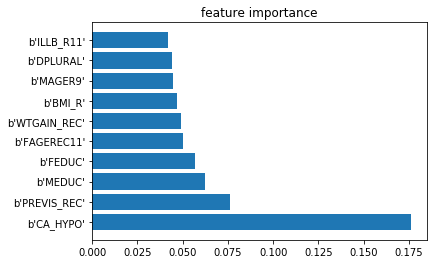

In [21]:
# Plot
features_top10 = sorted_features[:10]
featureNames, featureScores = zip(*list(features_top10))
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.title('feature importance')


In [22]:
#Thanks Drucila!
feature_importance = 100.0 * (randomForest.feature_importances_ / randomForest.feature_importances_.max())
important_features = X_train.columns[feature_importance >= 10]
unimportant_features = X_train.columns[feature_importance < 5]

In [23]:
important_features

Index(['MAGER9', 'RESTATUS', 'MRACEHISP', 'MEDUC', 'FAGEREC11', 'FRACEHISP',
       'FEDUC', 'PRIORTERM', 'TBO_REC', 'ILLB_R11', 'PRECARE5', 'PREVIS_REC',
       'WIC', 'BMI_R', 'WTGAIN_REC', 'RF_GHYPE', 'DPLURAL', 'RANDOM'],
      dtype='object')

In [24]:
unimportant_features

Index(['PRIORDEAD', 'CIG1_R', 'CIG2_R', 'RF_PDIAB', 'RF_GDIAB', 'RF_PHYPE',
       'RF_EHYPE', 'RF_INFTR', 'RF_FEDRG', 'RF_ARTEC', 'RF_CESAR', 'RF_CESARN',
       'IP_GON', 'IP_SYPH', 'IP_CHLAM', 'IP_HEPB', 'IP_HEPC', 'CA_ANEN',
       'CA_MNSB', 'CA_CCHD', 'CA_CDH', 'CA_OMPH', 'CA_GAST', 'CA_LIMB',
       'CA_CLEFT', 'CA_CLPAL', 'CA_DOWN', 'CA_DISOR', 'CA_HYPO'],
      dtype='object')